In [10]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from utils import read_PTB

os.chdir('C:\\Users\\Lough\\Desktop\\Research\\PhD Computer Science\\Conferences\\AIME 2024\\VCGEN')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dataset = read_PTB(clean = True)

100%|██████████| 549/549 [01:12<00:00,  7.56it/s]


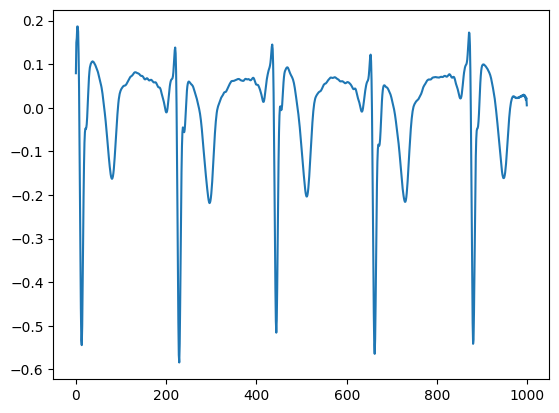

In [12]:
from matplotlib import pyplot as plt
plt.plot(dataset[50][0][:,2])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([549, 574])


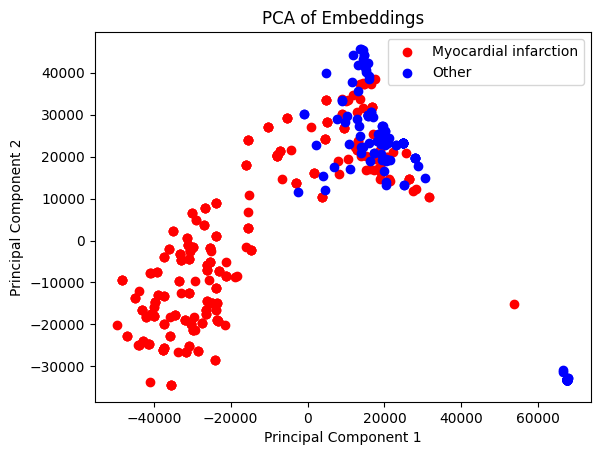

In [13]:
from transform import TextEmbedder
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence

embedder = TextEmbedder()
embeddings = []
labels = []
for i in range(len(dataset)):
    text = ' '.join(dataset[i][1])
    embedding = embedder.embed('bioBert', text)
    if('Myocardial infarction' in text):
        labels.append(0)
    else:
        labels.append(1)
    embeddings.append(embedding.flatten())

padded_embeddings = pad_sequence(embeddings, batch_first=True)
print(padded_embeddings.shape)

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(np.array(padded_embeddings))

labels = np.array(labels)

plt.scatter(pca_embeddings[labels==0, 0], pca_embeddings[labels==0, 1], c='red', label='Myocardial infarction')
plt.scatter(pca_embeddings[labels==1, 0], pca_embeddings[labels==1, 1], c='blue', label='Other')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Embeddings')
plt.legend()
plt.show()

In [14]:
from utils import compute_distances
from transform import VCGTransform

ecg_dataset = [dataset[i][0] for i in range(len(dataset))]

vcg_transformer = VCGTransform(ecg_dataset)
kors_dataset = vcg_transformer.ecg2vcg('kors')
idt_dataset = vcg_transformer.ecg2vcg('inverse_dower')
qlsv_dataset = vcg_transformer.ecg2vcg('qlsv')


vcg_dataset = [dataset[i][0][:,-3:] for i in range(len(dataset))]
kors_res = compute_distances(vcg_dataset, kors_dataset)
idt_res = compute_distances(vcg_dataset, idt_dataset)
qlsv_res = compute_distances(vcg_dataset, qlsv_dataset)

print('KORS RESULTS')
for k in kors_res.keys():
    print(k, kors_res[k])
print('--------')
print('IDT RESULTS')
for k in idt_res.keys():
    print(k, idt_res[k])
print('--------')
print('QLSV RESULTS')
for k in qlsv_res.keys():
    print(k, qlsv_res[k])

KORS RESULTS
MAE 0.023555976746935436
MSE 0.0027742346923187743
RMSE 0.04257112729530732
Correlation [0.8882661318702729, 0.8011444997544656, 0.7797189354057914]
Relative Deviation []
--------
IDT RESULTS
MAE 0.03970909608490596
MSE 0.008374342232061007
RMSE 0.07548108862982392
Correlation [0.8465325672370311, 0.7645290752884059, 0.7506171487600029]
Relative Deviation []
--------
QLSV RESULTS
MAE 0.02871919071771625
MSE 0.003590569808359513
RMSE 0.0485059767491034
Correlation [0.8746643703263438, 0.7865195516262729, 0.7606816846617886]
Relative Deviation []


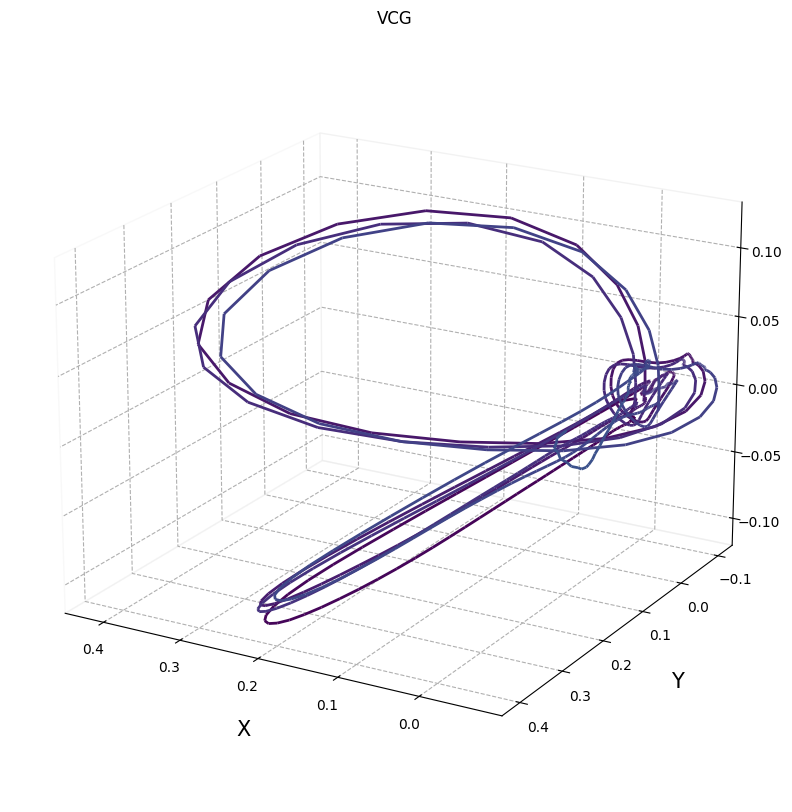

In [15]:
from utils import vcgplot

vcgplot(vcg_dataset[100], 4000)

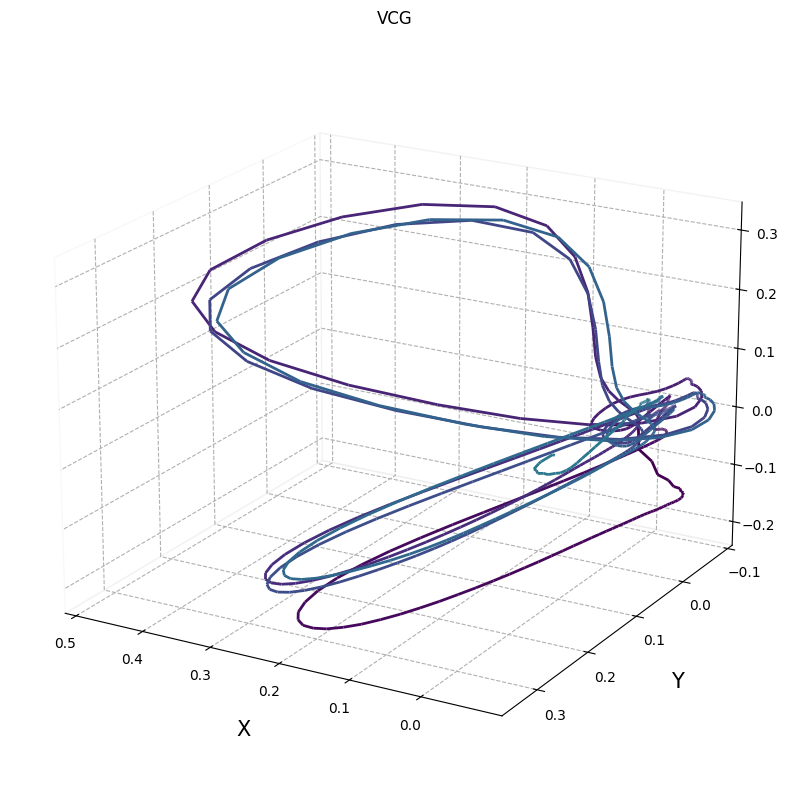

In [16]:
vcgplot(np.array([idt_dataset[100][:,0],idt_dataset[100][:,1],idt_dataset[100][:,2]]).T, 2500)

In [24]:
dataset[0][0].shape

(1000, 15)

torch.Size([1000, 3]) torch.Size([1000, 3])


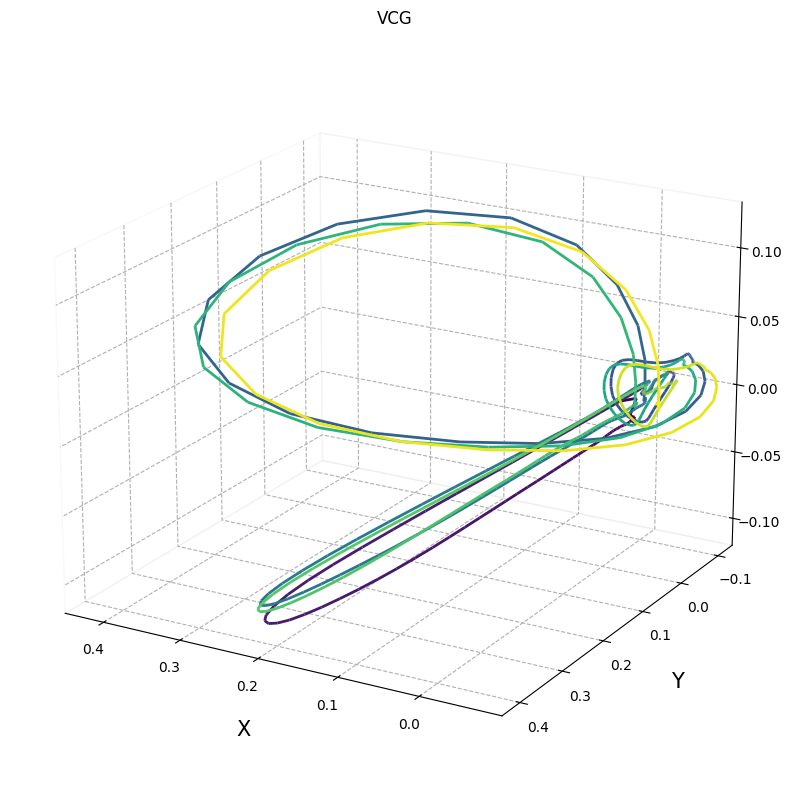

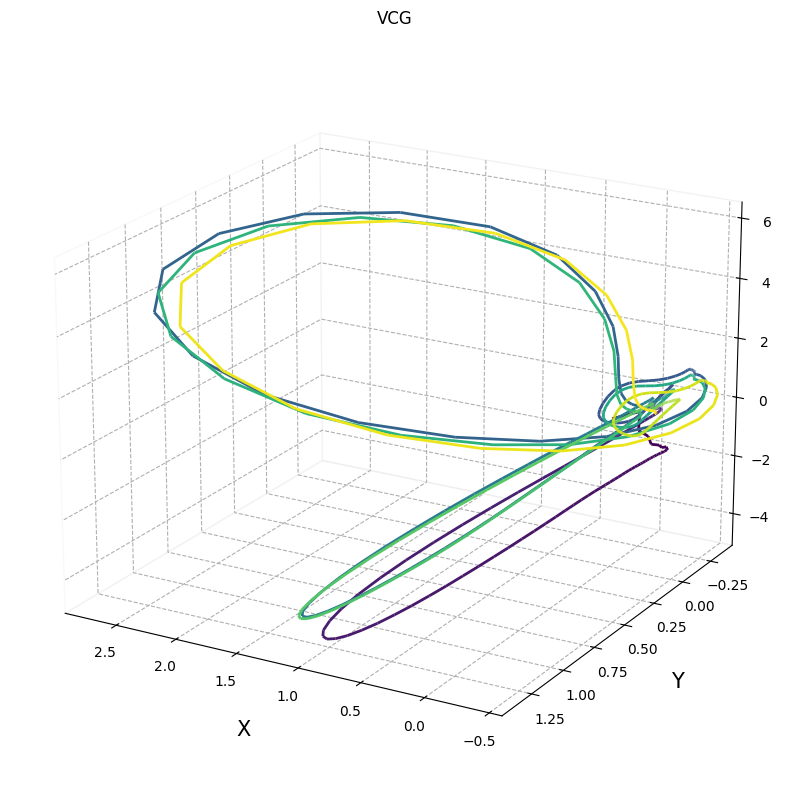

In [67]:
import torch

i = 100
E = torch.tensor(dataset[100][0][:,:12]).T
V = torch.tensor(vcg_dataset[100].T)

M = torch.linalg.lstsq(V.T, E.T).solution

Vm = torch.matmul(M,E)
mse = torch.mean(torch.square(V - torch.matmul(M,E)))

print(V.t().shape, Vm.t().shape)
vcgplot(np.array(V).T, 800)
vcgplot(np.array(Vm).T, 800)

In [152]:
import torch.nn as nn
import torch.optim as optim
from regression import ECGregression, ECGDataset, train_model
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(ECGDataset(train_dataset), batch_size=64, shuffle=True)
val_loader = DataLoader(ECGDataset(val_dataset), batch_size=64, shuffle=True)

model = ECGregression()
num_epochs, learning_rate = 100, 1e-4
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/100,                 Train Loss: 0.00048844,                Val Loss: 0.00046665


Epoch 2/100,                 Train Loss: 0.00045900,                Val Loss: 0.00042890


Epoch 3/100,                 Train Loss: 0.00043622,                Val Loss: 0.00040249


Epoch 4/100,                 Train Loss: 0.00041136,                Val Loss: 0.00039145


Epoch 5/100,                 Train Loss: 0.00038671,                Val Loss: 0.00036751


Epoch 6/100,                 Train Loss: 0.00036125,                Val Loss: 0.00033927


Epoch 7/100,                 Train Loss: 0.00034027,                Val Loss: 0.00031486


Epoch 8/100,                 Train Loss: 0.00031903,                Val Loss: 0.00028509


Epoch 9/100,                 Train Loss: 0.00029882,                Val Loss: 0.00026725


Epoch 10/100,                 Train Loss: 0.00027675,                Val Loss: 0.00024609


Epoch 11/100,                 Train Loss: 0.00025674,                Val Loss: 0.00022666


Epoch 12/100,                 Train Loss: 0.00023559,                Val Loss: 0.00020153


Epoch 13/100,                 Train Loss: 0.00021498,                Val Loss: 0.00018908


Epoch 14/100,                 Train Loss: 0.00019299,                Val Loss: 0.00017144


Epoch 15/100,                 Train Loss: 0.00017259,                Val Loss: 0.00016180


Epoch 16/100,                 Train Loss: 0.00015210,                Val Loss: 0.00015122


Epoch 17/100,                 Train Loss: 0.00013428,                Val Loss: 0.00014498


Epoch 18/100,                 Train Loss: 0.00011963,                Val Loss: 0.00013347


Epoch 19/100,                 Train Loss: 0.00010553,                Val Loss: 0.00013527


Epoch 20/100,                 Train Loss: 0.00009494,                Val Loss: 0.00012077


Epoch 21/100,                 Train Loss: 0.00008690,                Val Loss: 0.00012641


Epoch 22/100,                 Train Loss: 0.00007928,                Val Loss: 0.00011128


Epoch 23/100,                 Train Loss: 0.00007307,                Val Loss: 0.00010009


Epoch 24/100,                 Train Loss: 0.00006859,                Val Loss: 0.00009959


Epoch 25/100,                 Train Loss: 0.00006441,                Val Loss: 0.00009711


Epoch 26/100,                 Train Loss: 0.00006133,                Val Loss: 0.00008818


Epoch 27/100,                 Train Loss: 0.00005789,                Val Loss: 0.00007988


Epoch 28/100,                 Train Loss: 0.00005562,                Val Loss: 0.00007313


Epoch 29/100,                 Train Loss: 0.00005286,                Val Loss: 0.00006888


Epoch 30/100,                 Train Loss: 0.00005170,                Val Loss: 0.00006626


Epoch 31/100,                 Train Loss: 0.00004993,                Val Loss: 0.00006348


Epoch 32/100,                 Train Loss: 0.00004832,                Val Loss: 0.00005673


Epoch 33/100,                 Train Loss: 0.00004704,                Val Loss: 0.00005542


Epoch 34/100,                 Train Loss: 0.00004641,                Val Loss: 0.00005447


Epoch 35/100,                 Train Loss: 0.00004532,                Val Loss: 0.00005080


Epoch 36/100,                 Train Loss: 0.00004473,                Val Loss: 0.00005250


Epoch 37/100,                 Train Loss: 0.00004414,                Val Loss: 0.00004758


Epoch 38/100,                 Train Loss: 0.00004371,                Val Loss: 0.00004710


Epoch 39/100,                 Train Loss: 0.00004311,                Val Loss: 0.00004600


Epoch 40/100,                 Train Loss: 0.00004292,                Val Loss: 0.00004745


Epoch 41/100,                 Train Loss: 0.00004235,                Val Loss: 0.00004432


Epoch 42/100,                 Train Loss: 0.00004162,                Val Loss: 0.00004366


Epoch 43/100,                 Train Loss: 0.00004161,                Val Loss: 0.00004416


Epoch 44/100,                 Train Loss: 0.00004190,                Val Loss: 0.00004458


Epoch 45/100,                 Train Loss: 0.00004081,                Val Loss: 0.00004088


Epoch 46/100,                 Train Loss: 0.00004080,                Val Loss: 0.00004368


Epoch 47/100,                 Train Loss: 0.00004028,                Val Loss: 0.00004482


Epoch 48/100,                 Train Loss: 0.00004006,                Val Loss: 0.00004173


Epoch 49/100,                 Train Loss: 0.00004009,                Val Loss: 0.00004166


Epoch 50/100,                 Train Loss: 0.00003969,                Val Loss: 0.00004248


Epoch 51/100,                 Train Loss: 0.00003943,                Val Loss: 0.00004246


Epoch 52/100,                 Train Loss: 0.00003906,                Val Loss: 0.00004056


Epoch 53/100,                 Train Loss: 0.00003888,                Val Loss: 0.00004238


Epoch 54/100,                 Train Loss: 0.00003851,                Val Loss: 0.00004015


Epoch 55/100,                 Train Loss: 0.00003846,                Val Loss: 0.00004059


Epoch 56/100,                 Train Loss: 0.00003840,                Val Loss: 0.00004199


Epoch 57/100,                 Train Loss: 0.00003829,                Val Loss: 0.00004014


Epoch 58/100,                 Train Loss: 0.00003780,                Val Loss: 0.00003820


Epoch 59/100,                 Train Loss: 0.00003752,                Val Loss: 0.00004163


Epoch 60/100,                 Train Loss: 0.00003759,                Val Loss: 0.00003905


Epoch 61/100,                 Train Loss: 0.00003763,                Val Loss: 0.00004103


Epoch 62/100,                 Train Loss: 0.00003740,                Val Loss: 0.00004037


Epoch 63/100,                 Train Loss: 0.00003679,                Val Loss: 0.00003780


Epoch 64/100,                 Train Loss: 0.00003737,                Val Loss: 0.00003958


Epoch 65/100,                 Train Loss: 0.00003691,                Val Loss: 0.00004109


Epoch 66/100,                 Train Loss: 0.00003658,                Val Loss: 0.00004077


Epoch 67/100,                 Train Loss: 0.00003680,                Val Loss: 0.00003821


Epoch 68/100,                 Train Loss: 0.00003581,                Val Loss: 0.00003969


Epoch 69/100,                 Train Loss: 0.00003577,                Val Loss: 0.00003943


Epoch 70/100,                 Train Loss: 0.00003575,                Val Loss: 0.00003688


Epoch 71/100,                 Train Loss: 0.00003546,                Val Loss: 0.00003676


Epoch 72/100,                 Train Loss: 0.00003520,                Val Loss: 0.00003830


Epoch 73/100,                 Train Loss: 0.00003504,                Val Loss: 0.00003732


Epoch 74/100,                 Train Loss: 0.00003506,                Val Loss: 0.00003951


Epoch 75/100,                 Train Loss: 0.00003484,                Val Loss: 0.00003638


Epoch 76/100,                 Train Loss: 0.00003449,                Val Loss: 0.00003906


Epoch 77/100,                 Train Loss: 0.00003436,                Val Loss: 0.00003852


Epoch 78/100,                 Train Loss: 0.00003416,                Val Loss: 0.00003891


Epoch 79/100,                 Train Loss: 0.00003391,                Val Loss: 0.00003933


Epoch 80/100,                 Train Loss: 0.00003406,                Val Loss: 0.00003977


Epoch 81/100,                 Train Loss: 0.00003385,                Val Loss: 0.00003804


Epoch 82/100,                 Train Loss: 0.00003379,                Val Loss: 0.00004101


Epoch 83/100,                 Train Loss: 0.00003357,                Val Loss: 0.00003562


Epoch 84/100,                 Train Loss: 0.00003350,                Val Loss: 0.00003722


Epoch 85/100,                 Train Loss: 0.00003316,                Val Loss: 0.00003906


Epoch 86/100,                 Train Loss: 0.00003307,                Val Loss: 0.00003687


Epoch 87/100,                 Train Loss: 0.00003286,                Val Loss: 0.00003699


Epoch 88/100,                 Train Loss: 0.00003297,                Val Loss: 0.00003510


Epoch 89/100,                 Train Loss: 0.00003281,                Val Loss: 0.00003599


Epoch 90/100,                 Train Loss: 0.00003291,                Val Loss: 0.00003719


Epoch 91/100,                 Train Loss: 0.00003266,                Val Loss: 0.00003925


Epoch 92/100,                 Train Loss: 0.00003275,                Val Loss: 0.00003775


Epoch 93/100,                 Train Loss: 0.00003230,                Val Loss: 0.00003803


Epoch 94/100,                 Train Loss: 0.00003209,                Val Loss: 0.00003725


Epoch 95/100,                 Train Loss: 0.00003197,                Val Loss: 0.00003958


Epoch 96/100,                 Train Loss: 0.00003189,                Val Loss: 0.00003629


Epoch 97/100,                 Train Loss: 0.00003186,                Val Loss: 0.00003724


Epoch 98/100,                 Train Loss: 0.00003183,                Val Loss: 0.00003825


Epoch 99/100,                 Train Loss: 0.00003174,                Val Loss: 0.00003674


Epoch 100/100,                 Train Loss: 0.00003136,                Val Loss: 0.00003892


torch.Size([64, 3, 1000]) torch.Size([64, 3, 1000])
tensor(0.0021, dtype=torch.float64, grad_fn=<MeanBackward0>)


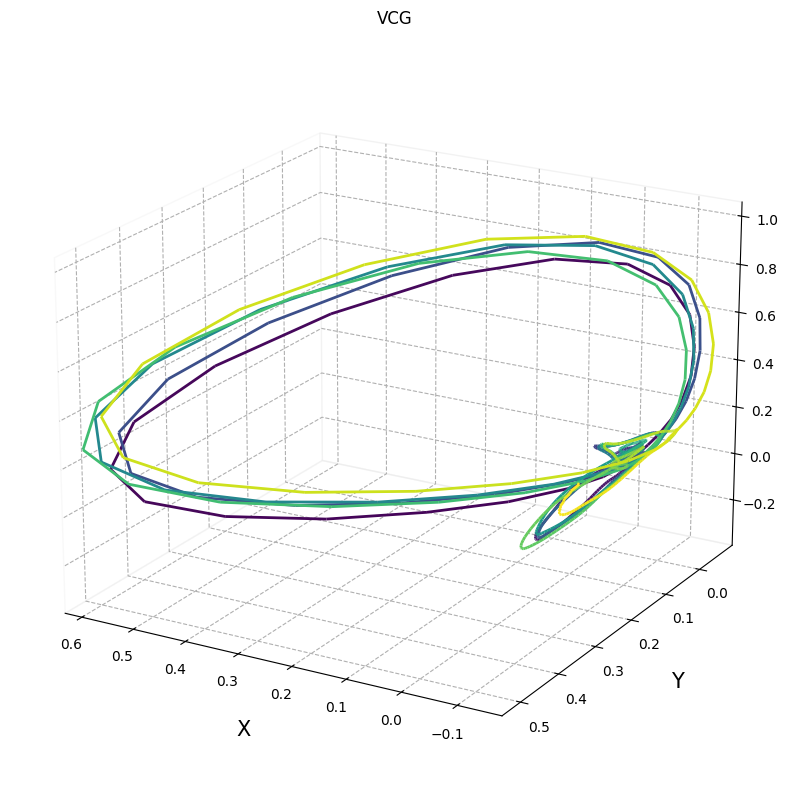

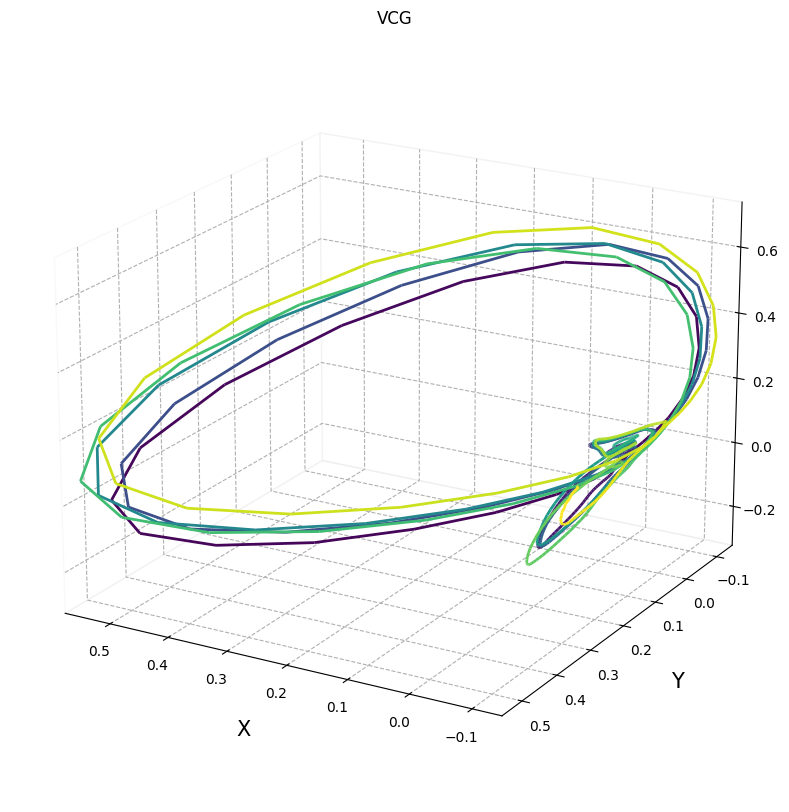

In [153]:
# Set the model to evaluation mode
model.eval()
batch = next(iter(train_loader))

input_data, target = batch
rec_vcg = model.reconstruct(input_data.float())

print(rec_vcg.shape, target.shape)
mse = torch.mean(torch.square(rec_vcg - target))
print(mse)

vcgplot(np.array(target[0,:,:].detach().T), 1000)
vcgplot(np.array(rec_vcg[0,:,:].detach().T), 1000)



torch.Size([64, 3, 1000]) torch.Size([64, 3, 1000])
tensor(0.0024, dtype=torch.float64, grad_fn=<MeanBackward0>)


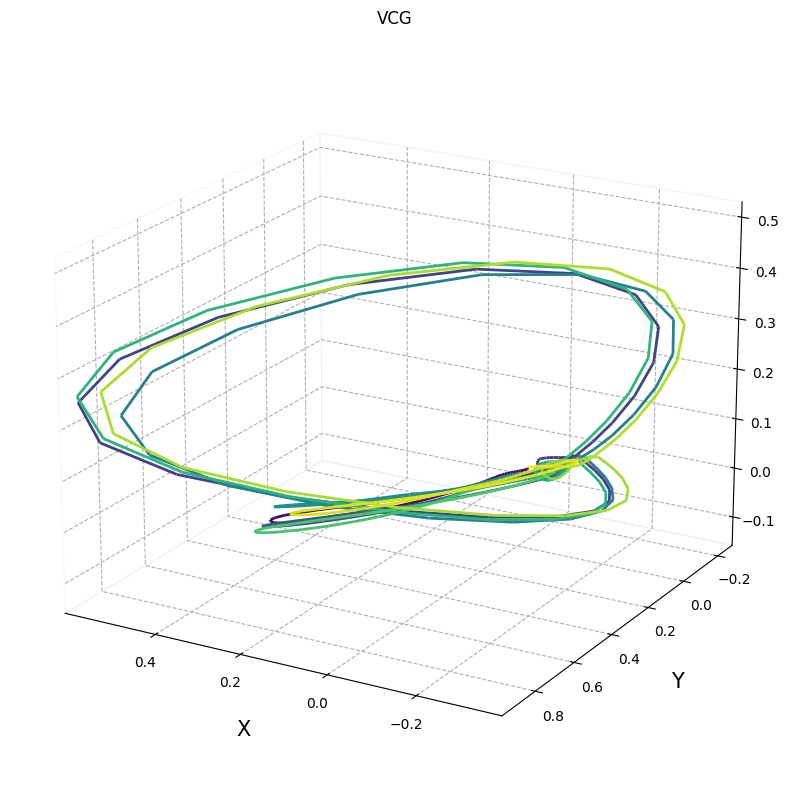

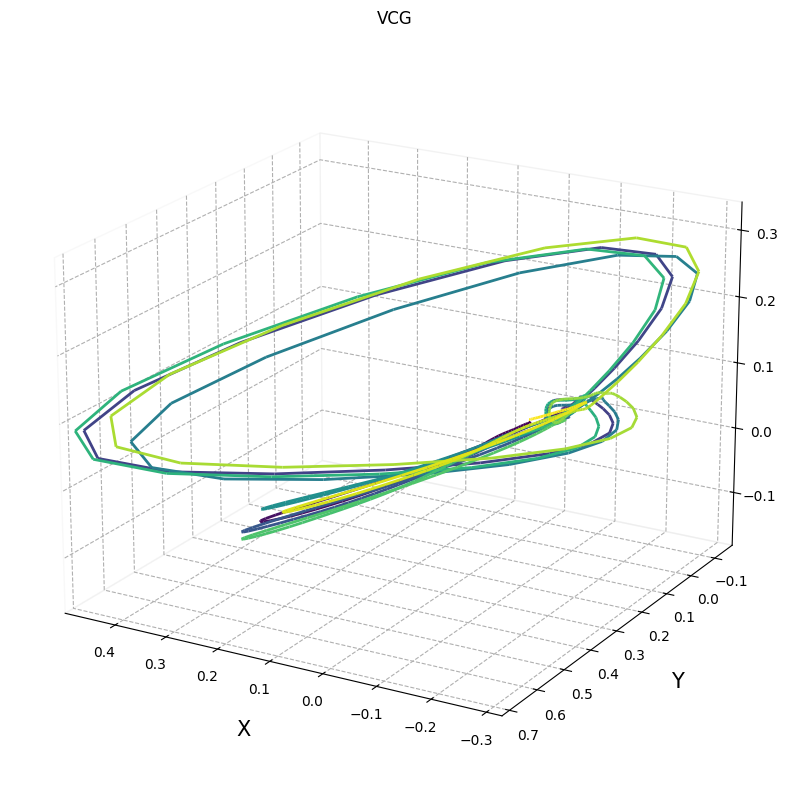

In [154]:
# Do the same but on evaluation
model.eval()
batch = next(iter(val_loader))

input_data, target = batch
rec_vcg = model.reconstruct(input_data.float())

print(rec_vcg.shape, target.shape)
mse = torch.mean(torch.square(rec_vcg - target))
print(mse)

vcgplot(np.array(target[0,:,:].detach().T), 1000)
vcgplot(np.array(rec_vcg[0,:,:].detach().T), 1000)



In [199]:
from utils import compute_distances
from transform import VCGTransform
from tabulate import tabulate

model.eval()
reg, kors, idt, qlsv = [], [], [], []
val_ecg, val_vcg = [], []

with torch.no_grad():
    for batch in val_loader:
        input_data, target = batch
        rec_vcg = model.reconstruct(input_data.float())
        reg.append(rec_vcg.transpose(1, 2))
        val_ecg.append(input_data.transpose(1, 2))
        val_vcg.append(target.transpose(1, 2))

val_ecg = torch.cat(val_ecg, dim=0).numpy()
val_vcg= torch.cat(val_vcg, dim=0).numpy()
reg= torch.cat(reg, dim=0).numpy()

vcg_transformer = VCGTransform(np.array(val_ecg))

kors = vcg_transformer.ecg2vcg('kors')
idt = vcg_transformer.ecg2vcg('inverse_dower')
qlsv = vcg_transformer.ecg2vcg('qlsv')

kors_res = compute_distances(val_vcg, kors)
idt_res = compute_distances(val_vcg, idt)
qlsv_res = compute_distances(val_vcg, qlsv)
reg_res = compute_distances(val_vcg, reg)

data = [
    ('REG RESULTS', reg_res),
    ('KORS RESULTS', kors_res),
    ('IDT RESULTS', idt_res),
    ('QLSV RESULTS', qlsv_res)
]

# Print the formatted table
for title, results in data:
    print(title)
    print(tabulate([(k, v) for k, v in results.items()], headers=["Metric", "Value"]))
    print('--------')

REG RESULTS
Metric              Value
------------------  ------------------------------------------------------------
MAE                 0.02056620029743347
MSE                 0.002051081257487125
RMSE                0.035983872916461955
Correlation         [0.9155439048317132, 0.8005799264732135, 0.7610757806153969]
Relative Deviation  []
--------
KORS RESULTS
Metric              Value
------------------  ------------------------------------------------------------
MAE                 0.02283385907144064
MSE                 0.0025705998144430484
RMSE                0.041315878336597
Correlation         [0.9100458563956504, 0.8005839322718401, 0.7554060584035812]
Relative Deviation  []
--------
IDT RESULTS
Metric              Value
------------------  ------------------------------------------------------------
MAE                 0.038611262288294514
MSE                 0.0073539045672899326
RMSE                0.07277546069634187
Correlation         [0.8678392591128353, 0.76631995